In [58]:
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

import cv2 as cv
import matplotlib.pyplot as plt

### Reading data

In [70]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data/dataset/',
  label_mode='categorical',
  shuffle=True,
  seed=42,
  image_size=(64, 64),
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'data/test_dataset/',
  label_mode='categorical',
  shuffle=True,
  seed=42,
  image_size=(64, 64),
)

train_X, train_y = zip(*train_ds)
train_X = np.concatenate(train_X)
train_y = np.concatenate(train_y)

test_X, test_y = zip(*test_ds)
test_X = np.concatenate(test_X)
test_y = np.concatenate(test_y)


Found 10019 files belonging to 10 classes.
Found 353 files belonging to 10 classes.


### Gray

In [71]:
def cvt_to_gray(images):
    gray_images = []
    for rgb_image in images:
        gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY)
        gray_images.append(gray_image)
    gray_images = np.array(gray_images)
    gray_images = gray_images[..., np.newaxis]
    return gray_images

In [72]:
gray_train_X = cvt_to_gray(train_X)
gray_test_X = cvt_to_gray(test_X)
gray_train_X.shape, gray_test_X.shape

((10019, 64, 64, 1), (353, 64, 64, 1))

### Gradients

In [73]:
def get_gradients(rgb_image):
    gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY) / 256
    
    sobelx = cv.Sobel(gray_image, cv.CV_64F,1,0,ksize=3)
    sobely = cv.Sobel(gray_image, cv.CV_64F,0,1,ksize=3)
    sobelxy = cv.Sobel(gray_image, cv.CV_64F,1,1,ksize=3)
    # laplacian = cv.Laplacian(gray_image, cv.CV_64F)
    
    return [sobelx, sobely, sobelxy]

In [74]:
def cvt_to_gradients(images):
    grad_images = []
    for rgb_image in images:
        gradients = get_gradients(rgb_image)
        grad_images.append(gradients)
    grad_images = np.array(grad_images)
    grad_images = np.transpose(grad_images, (0, 2, 3, 1))
    return grad_images

In [75]:
grad_train_X = cvt_to_gradients(train_X)
grad_test_X = cvt_to_gradients(test_X)
grad_train_X.shape, grad_test_X.shape

((10019, 64, 64, 3), (353, 64, 64, 3))

In [76]:
np.max(grad_train_X), np.min(grad_train_X)

(3.8386153373867273, -3.8688769042491913)

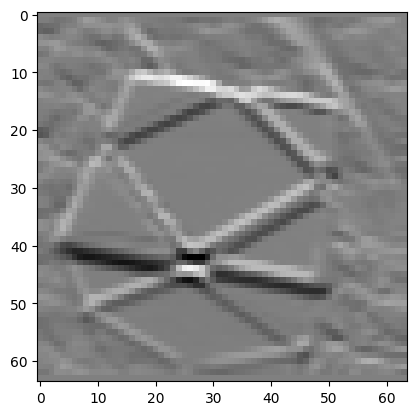

In [83]:
plt.imshow(grad_train_X[401, ..., 1], 'gray')

In [89]:
model = Sequential([
    layers.Input(shape=(None, None, 3)),
    layers.Resizing(64, 64),
    # layers.RandomFlip('horizontal'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

In [91]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_9 (Resizing)       (None, 64, 64, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 128)      

In [92]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [93]:
history = model.fit(grad_train_X, train_y, validation_data=(grad_test_X, test_y), epochs=40, batch_size=128)

Epoch 1/40
79/79 [==============================] - 2s 19ms/step - loss: 2.1013 - accuracy: 0.2079 - val_loss: 2.1697 - val_accuracy: 0.2720
Epoch 2/40
79/79 [==============================] - 1s 16ms/step - loss: 1.3201 - accuracy: 0.5326 - val_loss: 2.5748 - val_accuracy: 0.2606
Epoch 3/40
79/79 [==============================] - 1s 16ms/step - loss: 0.8752 - accuracy: 0.6950 - val_loss: 2.1528 - val_accuracy: 0.3739
Epoch 4/40
79/79 [==============================] - 1s 16ms/step - loss: 0.6312 - accuracy: 0.7854 - val_loss: 2.4738 - val_accuracy: 0.3683
Epoch 5/40
79/79 [==============================] - 1s 16ms/step - loss: 0.4187 - accuracy: 0.8598 - val_loss: 2.4995 - val_accuracy: 0.4476
Epoch 6/40
79/79 [==============================] - 1s 16ms/step - loss: 0.2787 - accuracy: 0.9113 - val_loss: 1.9834 - val_accuracy: 0.5609
Epoch 7/40
79/79 [==============================] - 1s 16ms/step - loss: 0.1890 - accuracy: 0.9414 - val_loss: 2.4344 - val_accuracy: 0.5326
Epoch 8/40
79

In [22]:
X, y = zip(*test_ds)
X = np.concatenate(X)
y = np.concatenate(y)

In [203]:
X.shape, y.shape

((72, 32, 32, 3), (72, 10))

In [69]:
X, y = zip(*test_ds)
X = np.concatenate(X)
y = np.concatenate(y)

predictions = model.predict(X)
report = classification_report(np.argmax(y, axis=1), np.argmax(predictions, axis=1))
print(report)

ValueError: in user code:

    File "c:\Users\Lukasz\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Lukasz\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Lukasz\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Lukasz\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Lukasz\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Lukasz\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_7" "                 f"(type Sequential).
    
    Input 0 of layer "conv2d_21" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 32, 32, 3)
    
    Call arguments received by layer "sequential_7" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 32, 32, 3), dtype=float32)
      • training=False
      • mask=None
